# MAST30034 Applied Data Science Project 2
## Merchant Forecast Notebook

This notebook forecasts future performances of each merchant, as features to feed into the final ranking model

**Key Performance Indicators:**
1. Average Take Amount (Take Rate * Dollar Value)
2. Transaction Volume

In [1]:
# Import Libraries
# !pip3 install tqdm
# !pip3 install pyramid-arima

from pyspark.sql import SparkSession, functions as F, DataFrame
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings

import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import pmdarima as pm

# Filter out some warnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

# Create spark session
spark = (
    SparkSession.builder.appName("Merchant Foreast")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/08 21:44:03 WARN Utils: Your hostname, Yis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.33.220 instead (on interface en0)
22/10/08 21:44:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 21:44:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read in preprocessed data
cleaned_data = spark.read.parquet('../data/curated/cleaned_data.parquet/')
cleaned_data = cleaned_data.withColumn("take_amt", F.col("take rate")*F.col("dollar_value")/100)

# Group Data and transform into time series data
ts = cleaned_data.groupBy(['merchant_abn', 'order_datetime']).agg(
    F.mean("take_amt").alias("mean_take_amt"),
    F.count("*").alias("transaction_count"),
)
ts_pd = ts.toPandas()
ts_pd = ts_pd.sort_values(by=['order_datetime','merchant_abn'])
ts_pd['order_datetime'] = pd.to_datetime(ts_pd['order_datetime'])

# Get the ABN's of all merchants in a set
merchants = sorted(set(ts_pd['merchant_abn']))

### **1. Determine Model for Forecasting**

As we have time series data in hand, we will use SARIMAX (Seasonal Auto-Regressive Integrated Moving Average), an autoregressive model that uses past data to forecast future data, using lagged values $(p)$, moving average $(q)$, differencing $(d)$, and seasonality $(P,D,Q,s)$.

The `SARIMAX` model takes a few hyperparameters $SARIMA(p,d,q)x(P,D,Q,s)$:
- We set $s=7$, since the granularity of the data is daily, and the closest period is a week (7 days)
- We use a stepwise algorithm (using AIC as selection criterion) to figure out the rest

Code adapted from: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/


In [3]:
# Use one merchant as an example to determine model
test_data = ts_pd.loc[ts_pd['merchant_abn']==10142254217]
test_data = test_data.set_index('order_datetime')

#### 1.1 Average Take Amount (take rate * dollar value)

From the output, `SARIMA(1,0,0)x(2,1,0,7)` is the best model, hence we use it in our final forecasting model

In [4]:
# Seasonal - fit stepwise auto-ARIMA
smodel_take_amt = pm.auto_arima(test_data['mean_take_amt'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_take_amt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  538
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood                -707.748
Date:                           Sat, 08 Oct 2022   AIC                           1423.495
Time:                                   21:47:40   BIC                           1440.594
Sample:                                        0   HQIC                          1430.187
                                           - 538                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0836      0.047     -1.764      0.078      -0.177       0.009
ar.S.L7       -0.6781      0.034    -19.868      0.000      -0.745      -0.611
ar.S.L14      -0.3832      0.035    -10.813      0.000      -0.453      -0.314
sigma2         0.8353      0.042     19.822      0.000       0.753       0.918
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.94
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.44
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 1.1.1 Visual Example

In [5]:
take_amt_test = sm.tsa.ARIMA(test_data['mean_take_amt'],order=(1,0,0) , seasonal_order=(2, 1, 0, 7))
take_amt_test_fit = take_amt_test.fit()

take_amt_test_forecast = take_amt_test_fit.get_forecast(steps = 365).predicted_mean

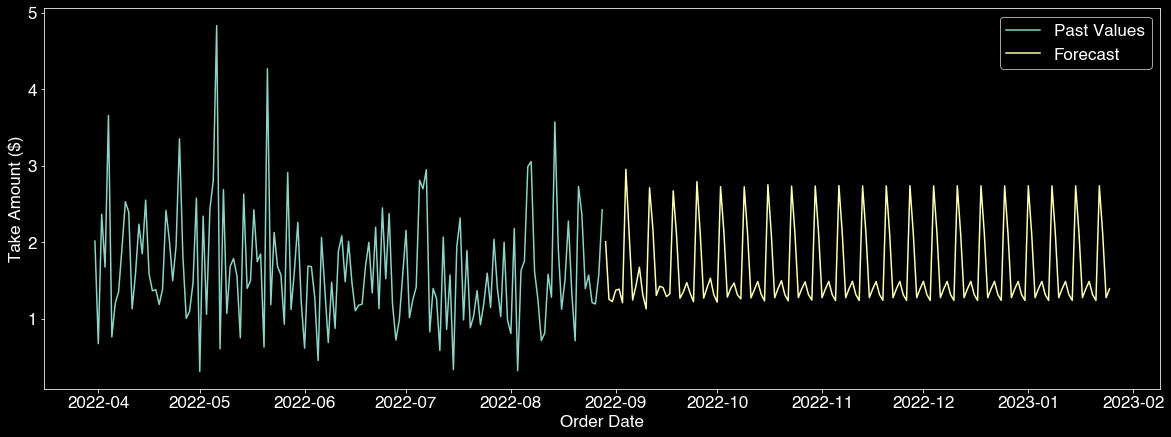

In [8]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plt.figure(figsize=(20, 7))
plt.style.use("dark_background")
plt.rcParams.update({'font.size': 17})

forecast_df = pd.DataFrame(data=take_amt_test_forecast.values, index=pd.date_range(start='2022-08-29',end='2023-08-28'))
plt.plot(test_data['mean_take_amt'].tail(150), label = "Past Values")
plt.plot(forecast_df.head(150), label = "Forecast")
plt.xlabel('Order Date')
plt.ylabel('Take Amount ($)')
plt.legend()

#### 1.2 Transaction Volume 

From the output, `SARIMA(1,0,1)x(2,1,0,7)` is the best model, hence we use it in our final forecasting model

In [7]:
# Seasonal - fit stepwise auto-ARIMA
smodel_transaction_count = pm.auto_arima(test_data['transaction_count'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_transaction_count.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  538
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 7)   Log Likelihood               -1392.128
Date:                            Sat, 08 Oct 2022   AIC                           2794.257
Time:                                    21:48:56   BIC                           2815.630
Sample:                                         0   HQIC                          2802.622
                                            - 538                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8020      0.107      7.519      0.000       0.593       1.011
ma.L1         -0.6930      0.125     -5.561      0.000      -0.937      -0.449
ar.S.L7       -0.6674      0.042    -15.937      0.000      -0.750      -0.585
ar.S.L14      -0.3312      0.040     -8.322      0.000      -0.409      -0.253
sigma2        11.0110      0.618     17.822      0.000       9.800      12.222
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                26.62
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.49
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **2. Deploy Model for Forecasting**

- For merchants with insufficient amount of data, a time series model cannot be built, hence we take the average of their data as our forecast
- For the rest, we build 2 `SARIMA` models for each merchant on 2 key performance indicators
    - We generate forecast for the next year (365 days, since we have about $\leq$ 2 years of data) and average it

In [9]:
static_merchant = []
for merchant in tqdm(merchants):
    
    merchant_data = ts_pd.loc[ts_pd['merchant_abn']==merchant]
    merchant_data = merchant_data.set_index('order_datetime')
    merchant_data = merchant_data.asfreq('D').fillna(0)

    if(len(set(merchant_data['mean_take_amt'])) <= 4 or len(set(merchant_data['transaction_count'])) <=4):
        static_merchant.append(merchant)

100%|██████████| 4422/4422 [00:31<00:00, 140.99it/s]


In [10]:
forecast = []

for merchant in tqdm(merchants):

    merchant_data = ts_pd.loc[ts_pd['merchant_abn']==merchant]
    merchant_data = merchant_data.set_index('order_datetime')
    merchant_data = merchant_data.asfreq('D').fillna(0)

    if(merchant in static_merchant):
        forecast.append([merchant, np.mean(merchant_data['mean_take_amt']), 
                                    np.mean(merchant_data['transaction_count'])])
        continue

    take_amt = sm.tsa.ARIMA(merchant_data['mean_take_amt'],order=(1,0,0) , seasonal_order=(2, 1, 0, 7))
    take_amt_fit = take_amt.fit()

    transaction_count = sm.tsa.ARIMA(merchant_data['transaction_count'],order=(1,0,1) , seasonal_order=(2, 1, 0, 7))
    transaction_count_fit = transaction_count.fit()

    take_amt_forecast = np.mean(take_amt_fit.get_forecast(steps = 365).predicted_mean)
    transaction_count_forecast = np.mean(transaction_count_fit.get_forecast(steps = 365).predicted_mean)

    forecast.append([merchant, take_amt_forecast, transaction_count_forecast])

100%|██████████| 4422/4422 [45:53<00:00,  1.61it/s]  


### **3. Output Forecast Results**

In [12]:
pd.DataFrame(forecast, columns = ['merchant_abn', 'mean_take_amt', 'transaction_count']).to_csv('../data/curated/future_predictions.csv')